In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, GaussianNoise
from tensorflow.keras.layers import Reshape, MaxPool2D, Conv2D, Conv2DTranspose
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
image_size = 28
x_train = np.reshape(x_train, [-1, image_size**2]).astype('float32') / 255
x_test = np.reshape(x_test, [-1, image_size**2]).astype('float32') / 255

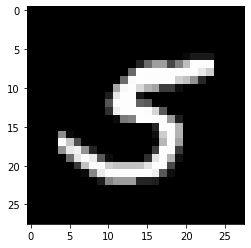

In [ ]:
plt.imshow(x_train[239].reshape([image_size, image_size]), cmap='gray')
plt.show()

In [ ]:
class MyConvAutoencoder(tf.keras.Model):
    '''
    Autoencoder consisting of a CNN encoder and a CNN decoder.  

    Attributes:
        latend_dim (int): Dimension of the latent space.
        reg_std (float, optional): Std for GaussianNoise layer during training. Defaults to 0.001. 
        encoder (tf.keras.Sequential): CNN encoder.
        decoder (tf.keras.Sequential): CNN decoder.
        
    '''

    def __init__(self, latent_dim):
        super(MyConvAutoencoder, self).__init__(name="my_conv_autoencoder")
        
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            Reshape((28, 28, 1), input_shape=(28**2,)),
            Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'),
            MaxPool2D(),
            BatchNormalization(),
            Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'),
            MaxPool2D(),
            BatchNormalization(),
            Flatten(),
            Dense(self.latent_dim, activation='sigmoid')
        ], name="my_encoder")

        self.decoder = tf.keras.Sequential([
            Dense(3136, input_shape=(self.latent_dim,), activation='relu'),
            Reshape((7, 7, 64)),
            BatchNormalization(),
            Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu'),
            BatchNormalization(),
            Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid'),
            Flatten()
        ], name="my_decoder")

    def call(self, inputs, training=False):
        latent = self.encoder(inputs)
        if training:
            latent = GaussianNoise(stddev=0.001)(latent)
        outputs = self.decoder(latent)
        return outputs

In [ ]:
autoencoder = MyConvAutoencoder(latent_dim=10)

autoencoder.compile(
    optimizer="adam", 
    loss="mse",
    metrics=["mae"]
)

In [ ]:
autoencoder.fit(x_train, x_train, epochs=100, batch_size=1024,
                validation_data=(x_test, x_test))

In [ ]:
autoencoder.load_weights('/content/drive/MyDrive/machine_learning/photomosaics/checkpoints/my_checkpoint_final')

In [ ]:
autoencoder.load_weights('/content/drive/MyDrive/machine_learning/photomosaics/checkpoints/check_point_10')

In [ ]:
preds = autoencoder.predict(x_train)

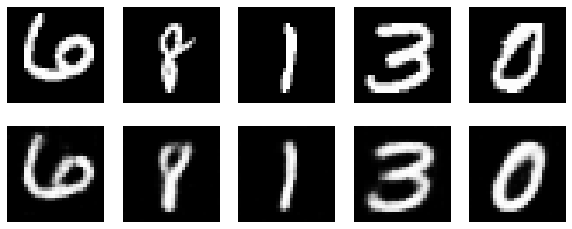

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
for i in range(5):
    ind = np.random.randint(0, x_test.shape[0])
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[0, i].imshow(x_train[ind].reshape([image_size, image_size]), cmap='gray')
    ax[1, i].imshow(preds[ind].reshape([image_size, image_size]), cmap='gray')
plt.show()

In [ ]:
def show_latent_distribution(model, data, labels, figsize=(10, 10), max_dims = 5):
    latent = model.encoder.predict(data)
    colors = ['darkred', 'peru', 'gold', 'lightgreen', 'aqua', 'darkorange', 'slategray', 
              'navy', 'darkviolet', 'deeppink']
    symbols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

    n_dims = min(model.latent_dim, max_dims)
    if n_dims == 2:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        plt.ylim(0.0, 1.07)
        for digit in range(10):
            mask = (labels == digit)
            ax.scatter(latent[mask, 0], latent[mask, 1], s=3, 
                       color=colors[digit], label=symbols[digit])
        plt.legend(loc='upper center', ncol=10)
        plt.axis('off')
        plt.show();
        return

    fig, ax = plt.subplots(n_dims, n_dims, 
                           figsize=(10 + min(10, n_dims * 2), 10 + min(10, n_dims * 2)))
    for x in range(n_dims):
        for y in range(n_dims):
            plt.ylim(0.0, 1.07)
            for digit in range(10):
                mask = (labels == digit)
                ax[x][y].scatter(latent[mask, x], latent[mask, y], s=1, 
                                 color=colors[digit], label=symbols[digit])
    plt.show();

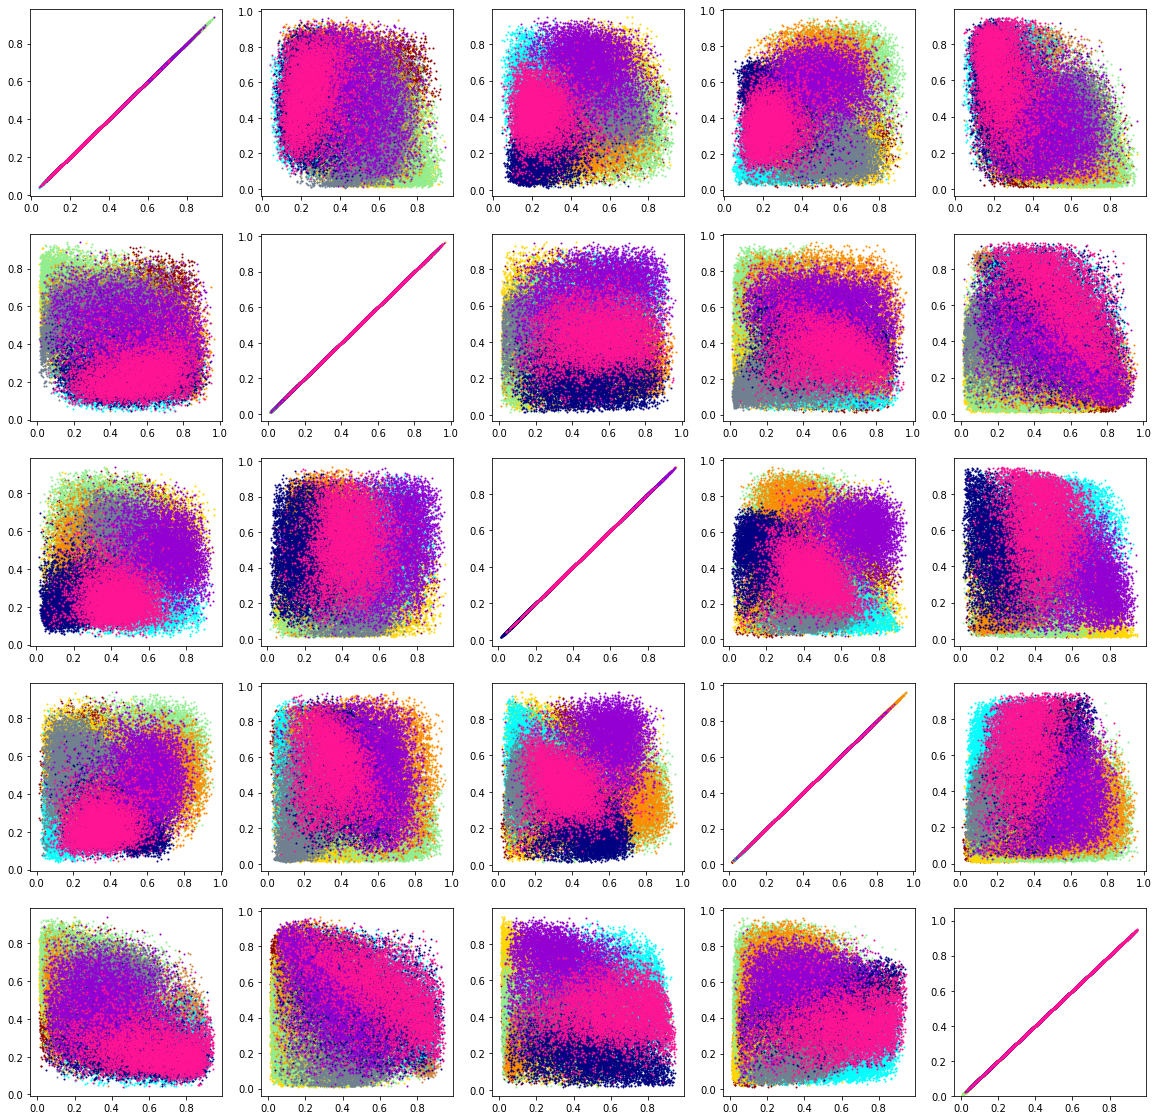

In [ ]:
show_latent_distribution(autoencoder, x_train, y_train)

In [ ]:
def print_meshgrid(model, n = 10, figsize=(10, 10)):
    step = 1.0 / n
    image = np.zeros((image_size * n, image_size * n))

    xv, yv = np.meshgrid(np.arange(0, n), np.arange(0, n), sparse=False, indexing='ij')
    latent = np.zeros((n**2, autoencoder.latent_dim)) + 0.5
    latent[:, 0:2] = np.concatenate((xv.reshape(-1, 1), yv.reshape(-1, 1)), axis=1) * step
    decoded = model.decoder.predict(latent).reshape([-1, image_size, image_size])

    for i in range(0, n):
        for j in range(0, n):
            image[i * image_size : (i + 1) * image_size, j * image_size : (j + 1) * image_size]\
                = decoded[j * n + (n-1-i)]
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

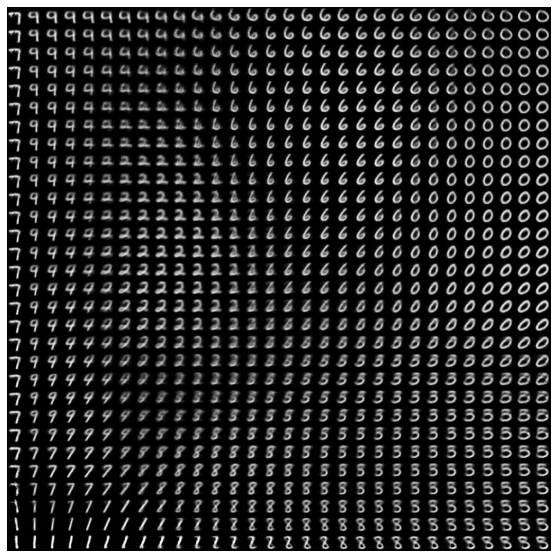

In [ ]:
print_meshgrid(autoencoder, 30)